In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path

# Для препроцессинга
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Для кластеризации
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Для оценки качества
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# Для визуализации
from sklearn.manifold import TSNE

# Настройки для воспроизводимости и визуализации
import random
random.seed(42)
np.random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline

In [2]:
# 3. Функции для вспомогательных задач
def save_metrics_to_json(metrics_summary, filename="metrics_summary.json"):
    """Сохранение метрик в JSON файл"""
    with open(f"artifacts/{filename}", "w") as f:
        json.dump(metrics_summary, f, indent=4)

def save_best_config(best_configs, filename="best_configs.json"):
    """Сохранение лучших конфигураций в JSON файл"""
    with open(f"artifacts/{filename}", "w") as f:
        json.dump(best_configs, f, indent=4)
        
def save_cluster_labels(sample_ids, labels, dataset_name):
    """Сохранение меток кластеров в CSV файл"""
    result_df = pd.DataFrame({
        "sample_id": sample_ids,
        "cluster_label": labels
    })
    result_df.to_csv(f"artifacts/labels/labels_hw07_{dataset_name}.csv", index=False)

def plot_silhouette_vs_k(X, k_range, dataset_name, random_state=42):
    """Построение графика silhouette_score от количества кластеров k"""
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Количество кластеров (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs K для {dataset_name}')
    plt.grid(True)
    plt.savefig(f"artifacts/figures/silhouette_vs_k_{dataset_name}.png", bbox_inches='tight')
    plt.show()
    
    return silhouette_scores

In [3]:
# 4. Загрузка и анализ данных для каждого датасета
datasets = {
    "ds1": "S07-hw-dataset-01.csv",
    "ds2": "S07-hw-dataset-02.csv",
    "ds4": "S07-hw-dataset-04.csv"
}

dataframes = {}
sample_ids = {}
features = {}

# Словари для сохранения результатов
metrics_summary = {}
best_configs = {}
all_labels = {}

for name, filename in datasets.items():
    print(f"\n{'='*50}")
    print(f"Анализ датасета: {name}")
    print(f"{'='*50}")
    
    # 4.1 Загрузка данных
    df = pd.read_csv(f"data/{filename}")
    dataframes[name] = df
    
    # 4.2 Первичный анализ
    print("\n--- Первые строки датасета ---")
    print(df.head())
    
    print("\n--- Информация о датасете ---")
    print(df.info())
    
    print("\n--- Базовые статистики ---")
    print(df.describe())
    
    # Проверка пропусков
    missing_values = df.isnull().sum()
    print("\n--- Пропущенные значения ---")
    print(missing_values[missing_values > 0])
    
    # Определение признаков и sample_id
    sample_ids[name] = df['sample_id'].copy()
    X = df.drop(columns=['sample_id'])
    features[name] = X.columns.tolist()
    
    print(f"\n--- Признаки для кластеризации ---")
    print(f"Всего признаков: {X.shape[1]}")
    print("Числовые признаки:", X.select_dtypes(include=[np.number]).columns.tolist())
    cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if cat_features:
        print("Категориальные признаки:", cat_features)
        for col in cat_features:
            print(f"Уникальные значения в '{col}': {X[col].unique()}")
    
    # Сохранение информации о датасете для отчета
    dataset_info = {
        "filename": filename,
        "shape": X.shape,
        "num_features": len(X.select_dtypes(include=[np.number]).columns),
        "cat_features": len(cat_features),
        "missing_values": int(missing_values.sum() - missing_values['sample_id'])
    }
    if name not in metrics_summary:
        metrics_summary[name] = {"dataset_info": dataset_info}


Анализ датасета: ds1

--- Первые строки датасета ---
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

--- Информация о датасете ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2  

In [4]:
# 5. Препроцессинг для каждого датасета
preprocessed_data = {}

# Dataset 1: S07-hw-dataset-01.csv (числовые признаки в разных шкалах + шум)
name = "ds1"
print(f"\n{'='*50}")
print(f"Препроцессинг для {name}")
print(f"{'='*50}")

X = dataframes[name].drop(columns=['sample_id'])
num_features = X.columns.tolist()

# Pipeline для масштабирования
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

X_processed = preprocessor.fit_transform(X)
preprocessed_data[name] = X_processed

print(f"Форма после препроцессинга: {X_processed.shape}")
print("Препроцессинг завершен для ds1")

# Dataset 2: S07-hw-dataset-02.csv (нелинейная структура + выбросы + шумовой признак)
name = "ds2"
print(f"\n{'='*50}")
print(f"Препроцессинг для {name}")
print(f"{'='*50}")

X = dataframes[name].drop(columns=['sample_id'])
num_features = X.columns.tolist()

# Pipeline для масштабирования
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

X_processed = preprocessor.fit_transform(X)
preprocessed_data[name] = X_processed

print(f"Форма после препроцессинга: {X_processed.shape}")
print("Препроцессинг завершен для ds2")

# Dataset 4: S07-hw-dataset-04.csv (высокая размерность + категориальные признаки + пропуски)
name = "ds4"
print(f"\n{'='*50}")
print(f"Препроцессинг для {name}")
print(f"{'='*50}")

X = dataframes[name].drop(columns=['sample_id'])

# Определение типов признаков
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Числовые признаки ({len(num_features)}): {num_features}")
print(f"Категориальные признаки ({len(cat_features)}): {cat_features}")

# Создание препроцессора для разных типов признаков
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

X_processed = preprocessor.fit_transform(X)
preprocessed_data[name] = X_processed

print(f"Форма после препроцессинга: {X_processed.shape}")
print("Препроцессинг завершен для ds4")


Препроцессинг для ds1
Форма после препроцессинга: (12000, 8)
Препроцессинг завершен для ds1

Препроцессинг для ds2
Форма после препроцессинга: (8000, 3)
Препроцессинг завершен для ds2

Препроцессинг для ds4
Числовые признаки (30): ['n01', 'n02', 'n03', 'n04', 'n05', 'n06', 'n07', 'n08', 'n09', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30']
Категориальные признаки (2): ['cat_a', 'cat_b']
Форма после препроцессинга: (10000, 42)
Препроцессинг завершен для ds4



Кластеризация для датасета: ds1

--- KMeans кластеризация ---
k=2: Silhouette=0.5216, DB=0.6853, CH=11786.9546
k=3: Silhouette=0.3968, DB=0.9646, CH=10446.6381
k=4: Silhouette=0.3833, DB=1.1603, CH=9427.4997
k=5: Silhouette=0.3548, DB=1.2737, CH=8301.2060
k=6: Silhouette=0.3586, DB=1.1823, CH=7333.3876
k=7: Silhouette=0.3246, DB=1.1942, CH=6823.0078
k=8: Silhouette=0.2689, DB=1.3142, CH=6460.8011
k=9: Silhouette=0.2534, DB=1.3440, CH=6255.2171
k=10: Silhouette=0.2629, DB=1.2770, CH=6084.5031

Лучшее количество кластеров для KMeans: k=2 (Silhouette=0.5216)


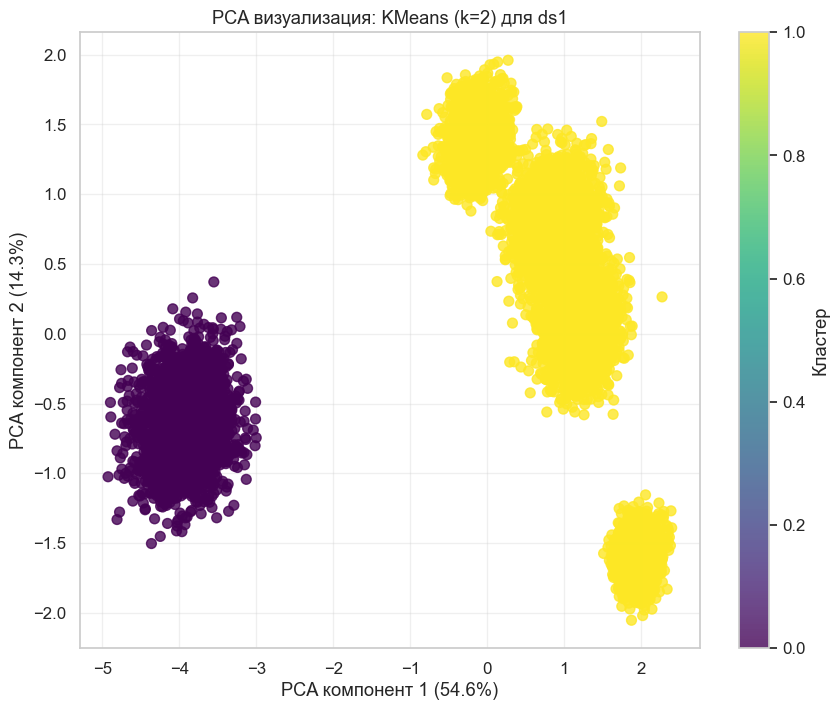

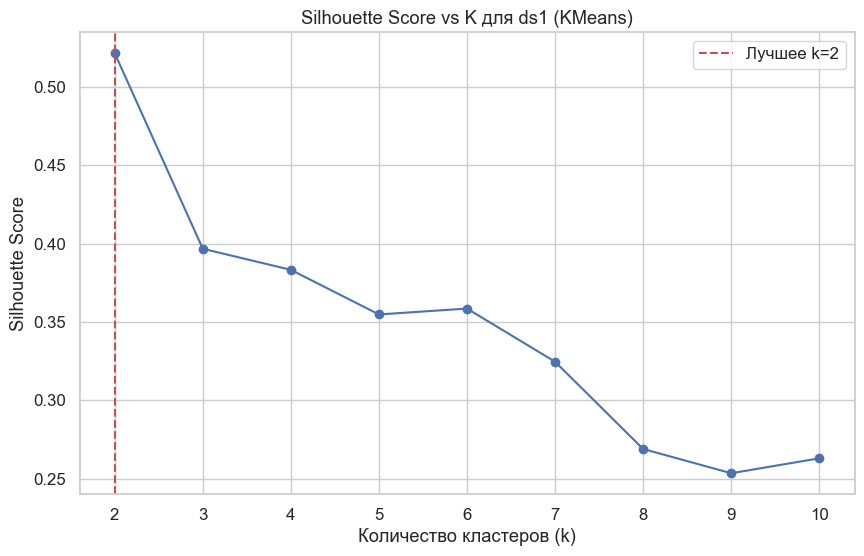


--- Второй алгоритм кластеризации ---
Применяется AgglomerativeClustering
linkage=ward: Silhouette=0.5216, DB=0.6853, CH=11786.9546
linkage=complete: Silhouette=0.5216, DB=0.6853, CH=11786.9546
linkage=average: Silhouette=0.5216, DB=0.6853, CH=11786.9546
linkage=single: Silhouette=0.5216, DB=0.6853, CH=11786.9546

Лучший linkage для AgglomerativeClustering: ward (Silhouette=0.5216)


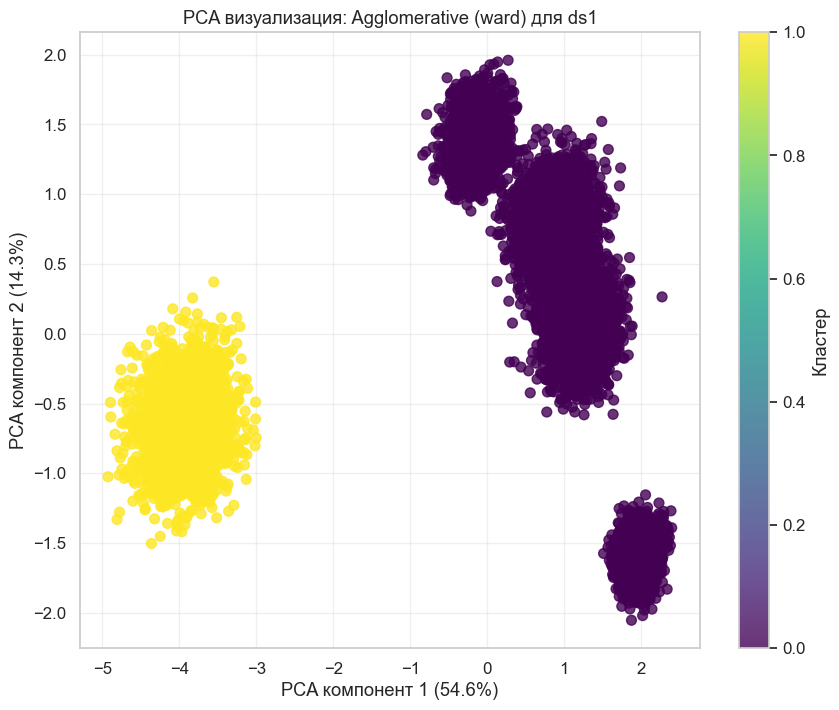

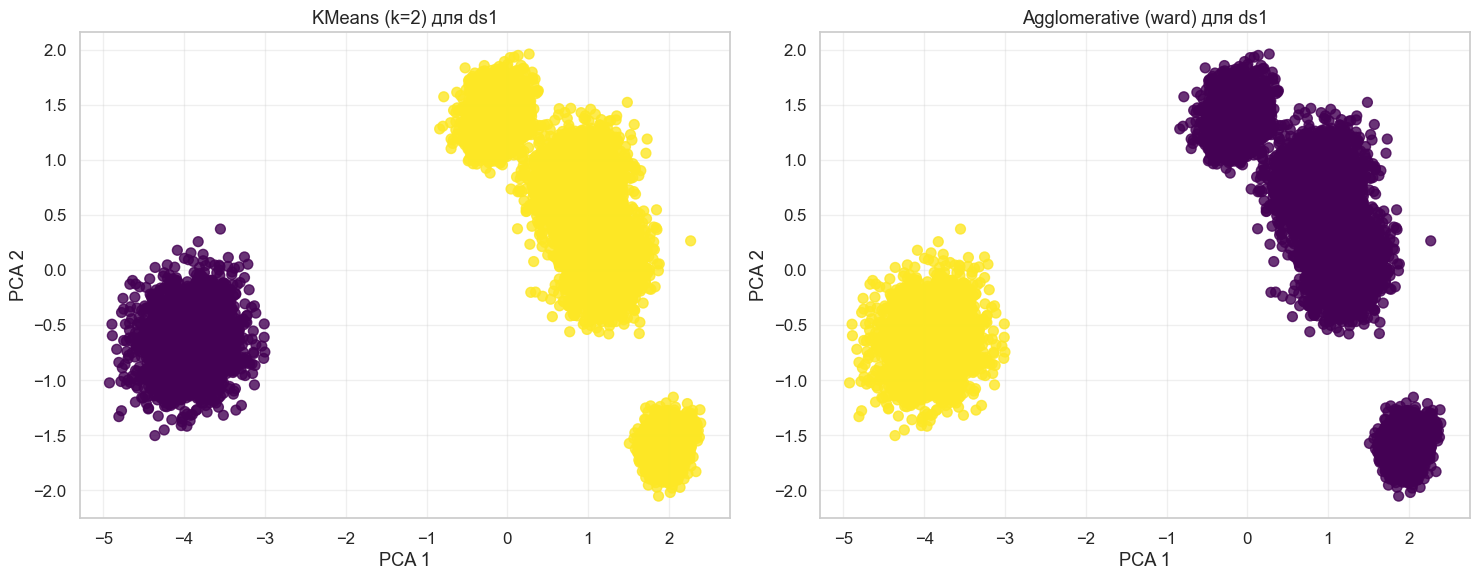


Выбор лучшей модели для ds1
KMeans (k=2): Silhouette=0.5216
Agglomerative (ward): Silhouette=0.5216

Выбран agglomerative как лучшая модель для ds1

Кластеризация для датасета: ds2

--- KMeans кластеризация ---
k=2: Silhouette=0.3069, DB=1.3235, CH=3573.3933
k=3: Silhouette=0.2700, DB=1.2227, CH=3082.2721
k=4: Silhouette=0.2515, DB=1.2998, CH=2915.5654
k=5: Silhouette=0.2521, DB=1.2138, CH=2703.5897
k=6: Silhouette=0.2598, DB=1.1595, CH=2571.0909
k=7: Silhouette=0.2536, DB=1.1723, CH=2453.5010
k=8: Silhouette=0.2523, DB=1.1002, CH=2408.5166
k=9: Silhouette=0.2525, DB=1.0896, CH=2379.9900
k=10: Silhouette=0.2609, DB=1.0571, CH=2408.1920

Лучшее количество кластеров для KMeans: k=2 (Silhouette=0.3069)


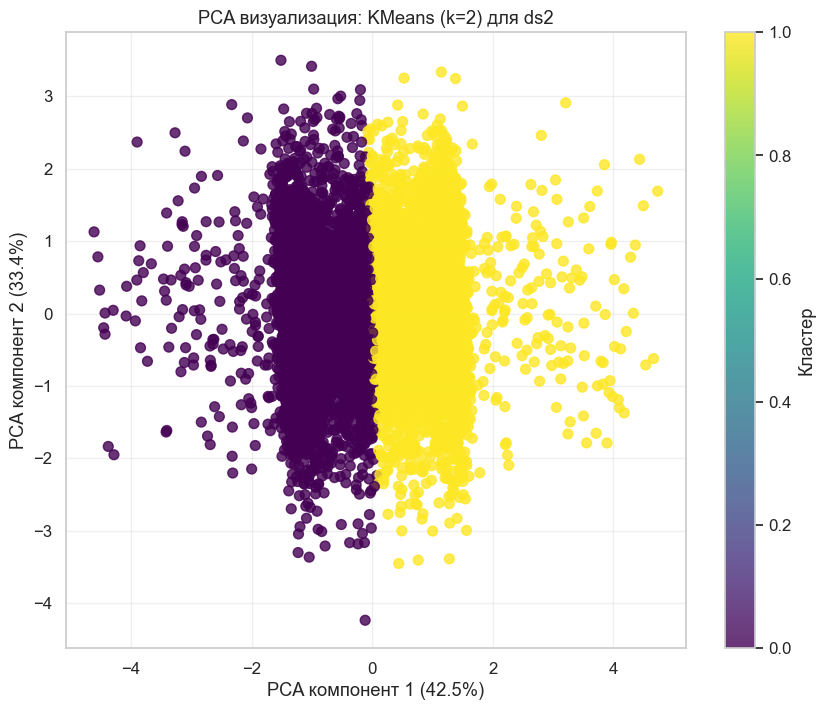

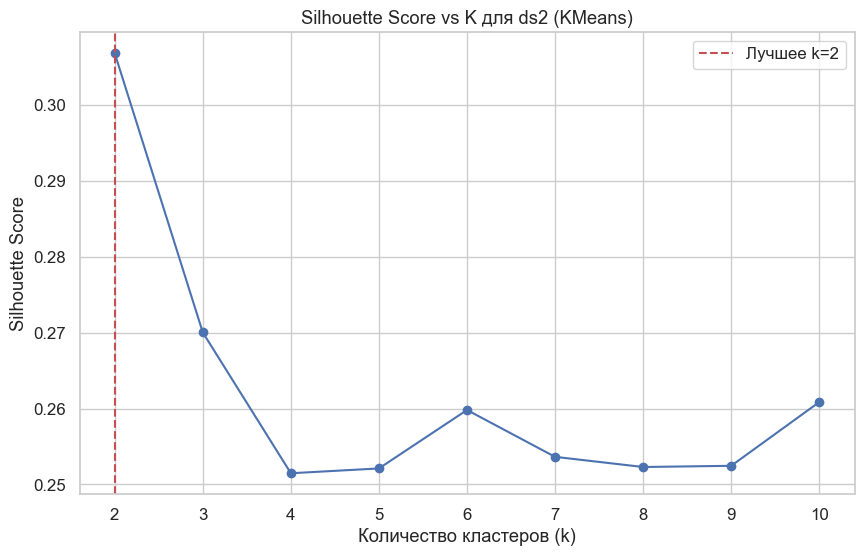


--- Второй алгоритм кластеризации ---
Применяется DBSCAN
eps=0.3, min_samples=5: Кластеров=5, Шум=7.24%, Silhouette=0.0852
eps=0.3, min_samples=10: Кластеров=1, Шум=8.59%, Silhouette=-1.0000
eps=0.3, min_samples=15: Кластеров=1, Шум=9.75%, Silhouette=-1.0000
eps=0.5, min_samples=5: Кластеров=14, Шум=4.50%, Silhouette=-0.0582
eps=0.5, min_samples=10: Кластеров=2, Шум=6.36%, Silhouette=0.2512
eps=0.5, min_samples=15: Кластеров=1, Шум=6.66%, Silhouette=-1.0000
eps=0.7, min_samples=5: Кластеров=1, Шум=0.99%, Silhouette=-1.0000
eps=0.7, min_samples=10: Кластеров=5, Шум=3.64%, Silhouette=0.3050
eps=0.7, min_samples=15: Кластеров=2, Шум=5.05%, Silhouette=0.3488
eps=1.0, min_samples=5: Кластеров=1, Шум=0.16%, Silhouette=-1.0000
eps=1.0, min_samples=10: Кластеров=1, Шум=0.31%, Silhouette=-1.0000
eps=1.0, min_samples=15: Кластеров=1, Шум=0.61%, Silhouette=-1.0000
eps=1.5, min_samples=5: Кластеров=1, Шум=0.00%, Silhouette=-1.0000
eps=1.5, min_samples=10: Кластеров=1, Шум=0.01%, Silhouette=-1.000

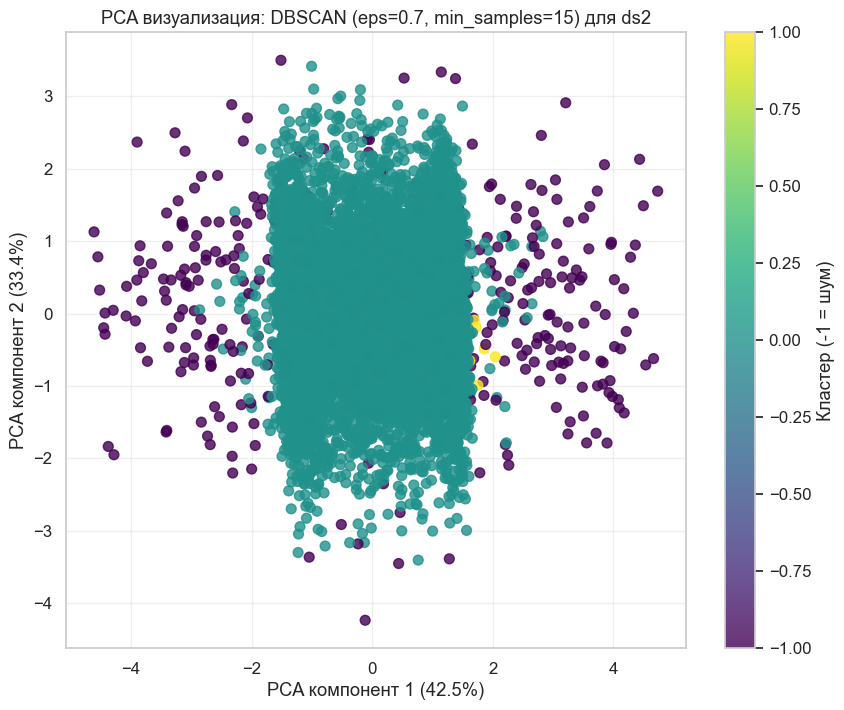

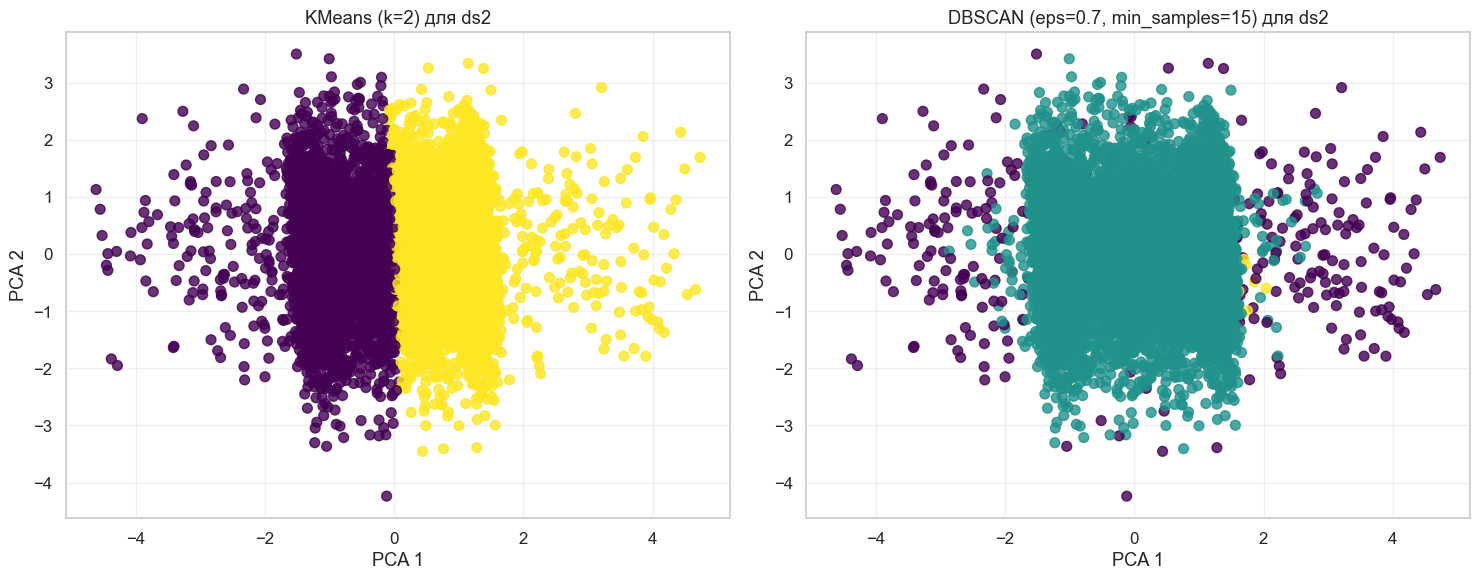


Выбор лучшей модели для ds2
KMeans (k=2): Silhouette=0.3069
DBSCAN (eps=0.7, min_samples=15): Silhouette=0.3488, Шум=5.05%

Выбран DBSCAN как лучшая модель для ds2

Кластеризация для датасета: ds4

--- KMeans кластеризация ---
k=2: Silhouette=0.2557, DB=1.6333, CH=3131.1820
k=3: Silhouette=0.2947, DB=1.4666, CH=3361.3337
k=4: Silhouette=0.3754, DB=1.1632, CH=3915.6915
k=5: Silhouette=0.4480, DB=0.9757, CH=5103.0998
k=6: Silhouette=0.4239, DB=1.0090, CH=5390.5414
k=7: Silhouette=0.3838, DB=1.6579, CH=4583.6104
k=8: Silhouette=0.3331, DB=2.0768, CH=4004.3656
k=9: Silhouette=0.2687, DB=2.4504, CH=3569.5685
k=10: Silhouette=0.1809, DB=2.7922, CH=3232.9915

Лучшее количество кластеров для KMeans: k=5 (Silhouette=0.4480)


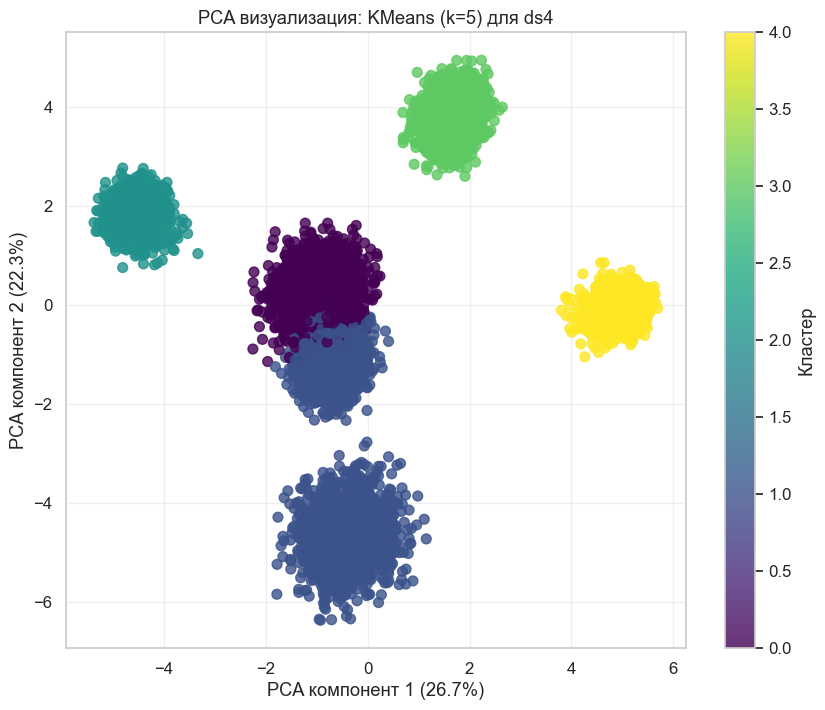

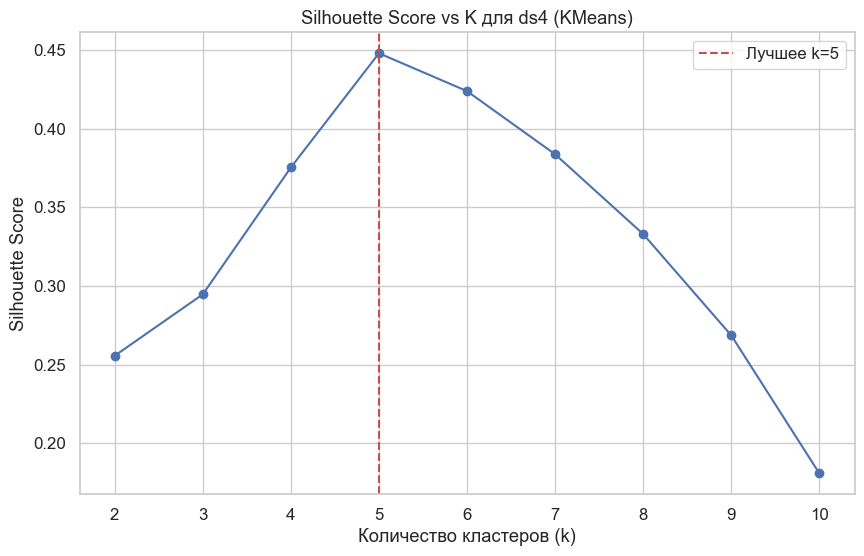


--- Второй алгоритм кластеризации ---
Применяется AgglomerativeClustering
linkage=ward: Silhouette=0.4480, DB=0.9757, CH=5103.0998
linkage=complete: Silhouette=0.4480, DB=0.9757, CH=5103.0998
linkage=average: Silhouette=0.4480, DB=0.9757, CH=5103.0998
linkage=single: Silhouette=0.4480, DB=0.9757, CH=5103.0998

Лучший linkage для AgglomerativeClustering: ward (Silhouette=0.4480)


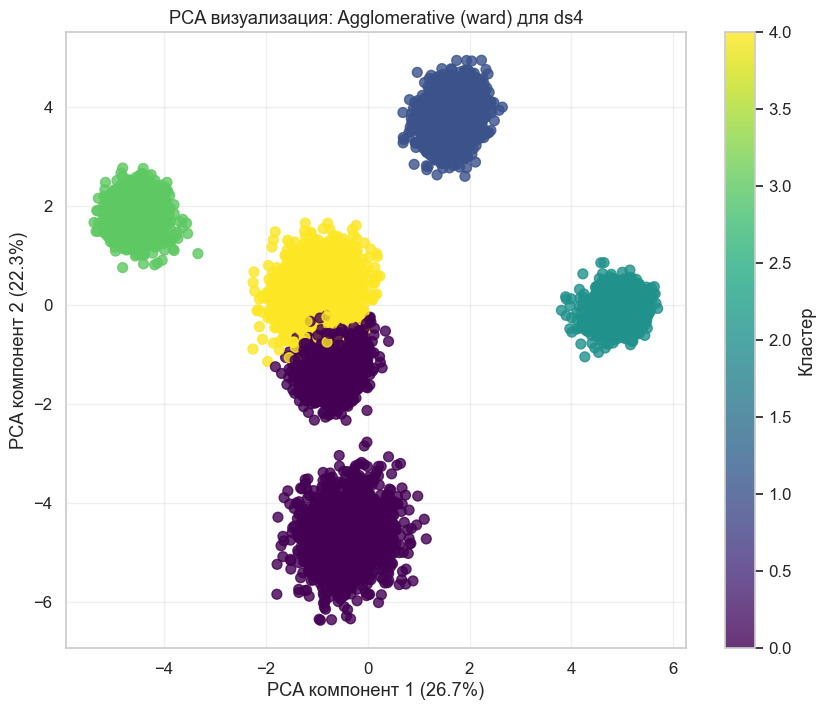

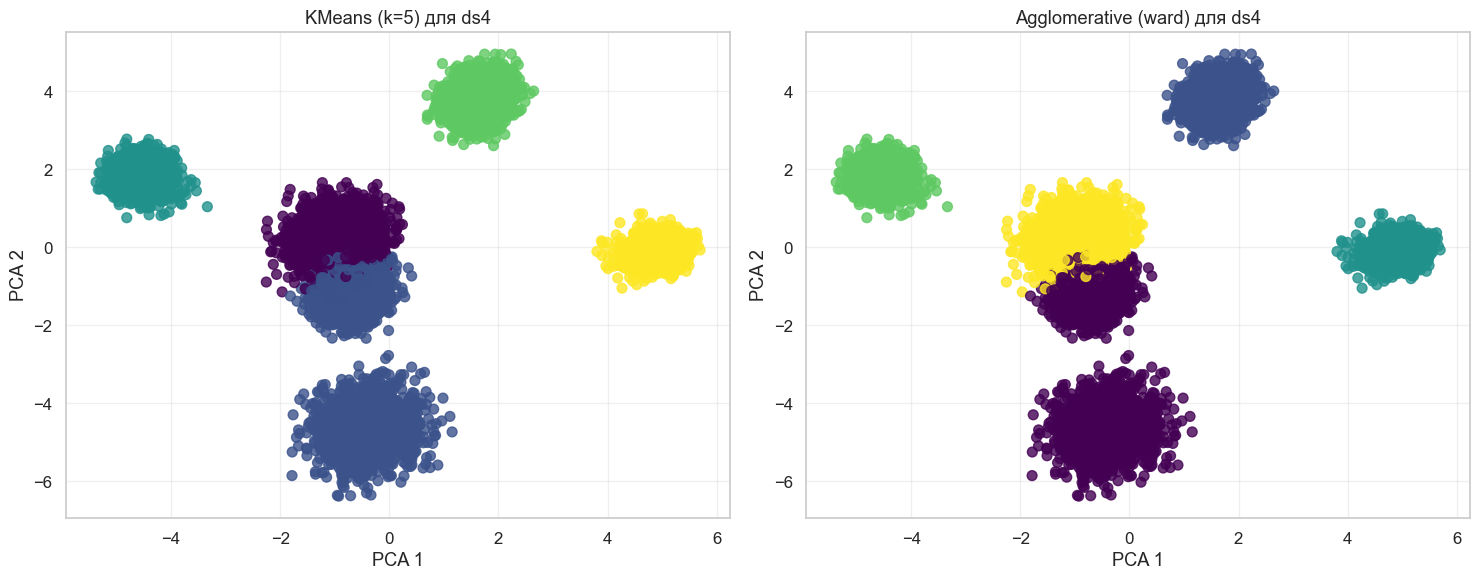


Выбор лучшей модели для ds4
KMeans (k=5): Silhouette=0.4480
Agglomerative (ward): Silhouette=0.4480

Выбран agglomerative как лучшая модель для ds4


In [5]:
# 6. Кластеризация для каждого датасета

from sklearn.base import clone

# Словарь для хранения PCA-компонентов для визуализации
pca_components = {}

for name, X_processed in preprocessed_data.items():
    print(f"\n{'='*60}")
    print(f"Кластеризация для датасета: {name}")
    print(f"{'='*60}")
    
    # Применение PCA для визуализации
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_processed)
    pca_components[name] = X_pca
    explained_variance = pca.explained_variance_ratio_.sum() * 100
    
    # Инициализация словаря для метрик этого датасета
    if name not in metrics_summary:
        metrics_summary[name] = {}
    
    # 6.1 KMeans кластеризация
    print("\n--- KMeans кластеризация ---")
    
    # Определение диапазона для k
    k_range = range(2, 11)
    best_k = None
    best_silhouette = -1
    kmeans_results = {}
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_processed)
        
        # Расчет метрик
        sil_score = silhouette_score(X_processed, labels)
        db_score = davies_bouldin_score(X_processed, labels)
        ch_score = calinski_harabasz_score(X_processed, labels)
        
        # Сохранение результатов
        kmeans_results[k] = {
            "silhouette": sil_score,
            "davies_bouldin": db_score,
            "calinski_harabasz": ch_score,
            "labels": labels.copy()
        }
        
        print(f"k={k}: Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.4f}")
        
        # Выбор лучшего k по silhouette_score
        if sil_score > best_silhouette:
            best_silhouette = sil_score
            best_k = k
    
    # Сохранение метрик KMeans для отчета
    metrics_summary[name]["kmeans"] = {
        k: {
            "silhouette": v["silhouette"],
            "davies_bouldin": v["davies_bouldin"],
            "calinski_harabasz": v["calinski_harabasz"]
        } for k, v in kmeans_results.items()
    }
    
    print(f"\nЛучшее количество кластеров для KMeans: k={best_k} (Silhouette={best_silhouette:.4f})")
    
    # Визуализация KMeans с лучшим k
    best_kmeans_labels = kmeans_results[best_k]["labels"]
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=best_kmeans_labels, 
                         cmap='viridis',
                         alpha=0.8,
                         s=50)
    plt.colorbar(scatter, label='Кластер')
    plt.title(f'PCA визуализация: KMeans (k={best_k}) для {name}')
    plt.xlabel(f'PCA компонент 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PCA компонент 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.savefig(f"artifacts/figures/pca_kmeans_{name}.png", bbox_inches='tight')
    plt.show()
    
    # График Silhouette vs k
    silhouette_scores = [kmeans_results[k]["silhouette"] for k in k_range]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Лучшее k={best_k}')
    plt.xlabel('Количество кластеров (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs K для {name} (KMeans)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"artifacts/figures/silhouette_kmeans_{name}.png", bbox_inches='tight')
    plt.show()
    
    # 6.2 DBSCAN кластеризация (для ds2) или AgglomerativeClustering (для ds1 и ds4)
    print("\n--- Второй алгоритм кластеризации ---")
    
    if name == "ds2":  # Для нелинейных структур лучше подходит DBSCAN
        print("Применяется DBSCAN")
        
        # Подбор параметров для DBSCAN
        eps_range = [0.3, 0.5, 0.7, 1.0, 1.5]
        min_samples_range = [5, 10, 15]
        
        best_dbscan = None
        best_dbscan_score = -1
        best_eps = None
        best_min_samples = None
        dbscan_results = {}
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X_processed)
                
                # Процент шума
                noise_ratio = np.sum(labels == -1) / len(labels)
                
                # Расчет метрик только для не-шумовых точек
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > 1 and len(np.unique(labels[non_noise_mask])) > 1:
                    sil_score = silhouette_score(X_processed[non_noise_mask], labels[non_noise_mask])
                    db_score = davies_bouldin_score(X_processed[non_noise_mask], labels[non_noise_mask])
                    ch_score = calinski_harabasz_score(X_processed[non_noise_mask], labels[non_noise_mask])
                else:
                    sil_score = -1  # Невозможно рассчитать
                    db_score = float('inf')
                    ch_score = 0
                
                dbscan_results[(eps, min_samples)] = {
                    "silhouette": sil_score,
                    "davies_bouldin": db_score,
                    "calinski_harabasz": ch_score,
                    "noise_ratio": noise_ratio,
                    "labels": labels.copy(),
                    "n_clusters": len(np.unique(labels[labels != -1]))
                }
                
                print(f"eps={eps}, min_samples={min_samples}: Кластеров={dbscan_results[(eps, min_samples)]['n_clusters']}, "
                      f"Шум={noise_ratio:.2%}, Silhouette={sil_score:.4f}")
                
                # Выбор лучшей конфигурации по silhouette_score
                if sil_score > best_dbscan_score and noise_ratio < 0.5:  # Ограничиваем долю шума
                    best_dbscan_score = sil_score
                    best_dbscan = (eps, min_samples)
                    best_eps = eps
                    best_min_samples = min_samples
        
        # Сохранение результатов DBSCAN для отчета
        metrics_summary[name]["dbscan"] = {
            f"eps={eps}_min_samples={min_samples}": {
                "silhouette": v["silhouette"],
                "davies_bouldin": v["davies_bouldin"],
                "calinski_harabasz": v["calinski_harabasz"],
                "noise_ratio": v["noise_ratio"],
                "n_clusters": v["n_clusters"]
            } for (eps, min_samples), v in dbscan_results.items()
        }
        
        print(f"\nЛучшие параметры для DBSCAN: eps={best_eps}, min_samples={best_min_samples} "
              f"(Silhouette={best_dbscan_score:.4f}, Шум={dbscan_results[best_dbscan]['noise_ratio']:.2%})")
        
        # Визуализация лучшего результата DBSCAN
        best_dbscan_labels = dbscan_results[best_dbscan]["labels"]
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=best_dbscan_labels, 
                             cmap='viridis',
                             alpha=0.8,
                             s=50)
        plt.colorbar(scatter, label='Кластер (-1 = шум)')
        plt.title(f'PCA визуализация: DBSCAN (eps={best_eps}, min_samples={best_min_samples}) для {name}')
        plt.xlabel(f'PCA компонент 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PCA компонент 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"artifacts/figures/pca_dbscan_{name}.png", bbox_inches='tight')
        plt.show()
        
        # Сравнение KMeans и DBSCAN
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_kmeans_labels, cmap='viridis', alpha=0.8, s=50)
        plt.title(f'KMeans (k={best_k}) для {name}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_dbscan_labels, cmap='viridis', alpha=0.8, s=50)
        plt.title(f'DBSCAN (eps={best_eps}, min_samples={best_min_samples}) для {name}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"artifacts/figures/comparison_{name}.png", bbox_inches='tight')
        plt.show()
        
    else:  # Для ds1 и ds4 используем AgglomerativeClustering
        print("Применяется AgglomerativeClustering")
        
        # Сравнение разных типов linkage
        linkages = ['ward', 'complete', 'average', 'single']
        best_linkage = None
        best_agg_score = -1
        agg_results = {}
        
        for linkage in linkages:
            try:
                agg = AgglomerativeClustering(n_clusters=best_k, linkage=linkage)
                labels = agg.fit_predict(X_processed)
                
                # Расчет метрик
                sil_score = silhouette_score(X_processed, labels)
                db_score = davies_bouldin_score(X_processed, labels)
                ch_score = calinski_harabasz_score(X_processed, labels)
                
                agg_results[linkage] = {
                    "silhouette": sil_score,
                    "davies_bouldin": db_score,
                    "calinski_harabasz": ch_score,
                    "labels": labels.copy()
                }
                
                print(f"linkage={linkage}: Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.4f}")
                
                # Выбор лучшего linkage по silhouette_score
                if sil_score > best_agg_score:
                    best_agg_score = sil_score
                    best_linkage = linkage
                    
            except Exception as e:
                print(f"Ошибка при linkage={linkage}: {str(e)}")
                continue
        
        # Сохранение результатов AgglomerativeClustering для отчета
        metrics_summary[name]["agglomerative"] = {
            linkage: {
                "silhouette": v["silhouette"],
                "davies_bouldin": v["davies_bouldin"],
                "calinski_harabasz": v["calinski_harabasz"]
            } for linkage, v in agg_results.items()
        }
        
        print(f"\nЛучший linkage для AgglomerativeClustering: {best_linkage} "
              f"(Silhouette={best_agg_score:.4f})")
        
        # Визуализация лучшего результата AgglomerativeClustering
        best_agg_labels = agg_results[best_linkage]["labels"]
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=best_agg_labels, 
                             cmap='viridis',
                             alpha=0.8,
                             s=50)
        plt.colorbar(scatter, label='Кластер')
        plt.title(f'PCA визуализация: Agglomerative ({best_linkage}) для {name}')
        plt.xlabel(f'PCA компонент 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PCA компонент 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"artifacts/figures/pca_agg_{name}.png", bbox_inches='tight')
        plt.show()
        
        # Сравнение KMeans и Agglomerative
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_kmeans_labels, cmap='viridis', alpha=0.8, s=50)
        plt.title(f'KMeans (k={best_k}) для {name}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_agg_labels, cmap='viridis', alpha=0.8, s=50)
        plt.title(f'Agglomerative ({best_linkage}) для {name}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"artifacts/figures/comparison_{name}.png", bbox_inches='tight')
        plt.show()
    
    # 6.3 Выбор лучшей модели и сохранение результатов
    print(f"\n{'='*40}")
    print(f"Выбор лучшей модели для {name}")
    print(f"{'='*40}")
    
    if name == "ds2":
        # Для ds2 сравниваем KMeans и DBSCAN
        kmeans_score = best_silhouette
        dbscan_score = best_dbscan_score
        noise_ratio = dbscan_results[best_dbscan]["noise_ratio"]
        
        print(f"KMeans (k={best_k}): Silhouette={kmeans_score:.4f}")
        print(f"DBSCAN (eps={best_eps}, min_samples={best_min_samples}): Silhouette={dbscan_score:.4f}, Шум={noise_ratio:.2%}")
        
        # Принимаем решение о лучшей модели
        if dbscan_score > kmeans_score and noise_ratio < 0.3:
            best_model = "dbscan"
            best_labels = best_dbscan_labels
            best_params = {"eps": best_eps, "min_samples": best_min_samples, "noise_ratio": noise_ratio}
            print(f"\nВыбран DBSCAN как лучшая модель для {name}")
        else:
            best_model = "kmeans"
            best_labels = best_kmeans_labels
            best_params = {"k": best_k}
            print(f"\nВыбран KMeans как лучшая модель для {name}")
            
    else:
        # Для ds1 и ds4 сравниваем KMeans и Agglomerative
        kmeans_score = best_silhouette
        agg_score = best_agg_score
        
        print(f"KMeans (k={best_k}): Silhouette={kmeans_score:.4f}")
        print(f"Agglomerative ({best_linkage}): Silhouette={agg_score:.4f}")
        
        best_model = "kmeans" if kmeans_score > agg_score else "agglomerative"
        best_labels = best_kmeans_labels if best_model == "kmeans" else best_agg_labels
        best_params = {"k": best_k} if best_model == "kmeans" else {"linkage": best_linkage, "k": best_k}
        
        print(f"\nВыбран {best_model} как лучшая модель для {name}")
        
        # Для Agglomerative сохраняем дополнительную информацию
        if best_model == "agglomerative":
            best_params["silhouette"] = agg_score
    
    # Сохранение информации о лучшей модели
    best_configs[name] = {
        "best_model": best_model,
        "params": best_params,
        "silhouette": kmeans_score if best_model == "kmeans" else (best_dbscan_score if name == "ds2" else agg_score)
    }
    
    # Сохранение меток кластеров для лучшей модели
    all_labels[name] = best_labels
    save_cluster_labels(sample_ids[name], best_labels, name)


Проверка устойчивости для ds1
Запуск 2 (random_state=42): ARI по сравнению с первым запуском = 1.0000
Запуск 3 (random_state=84): ARI по сравнению с первым запуском = 1.0000
Запуск 4 (random_state=126): ARI по сравнению с первым запуском = 1.0000
Запуск 5 (random_state=168): ARI по сравнению с первым запуском = 1.0000

Средний ARI между запусками: 1.0000 ± 0.0000


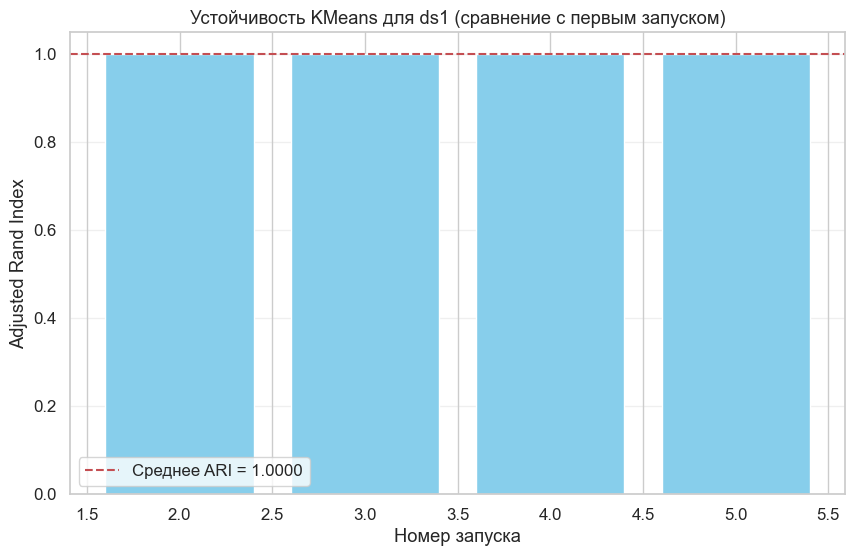

In [6]:
# 7. Проверка устойчивости (только для одного датасета, выберем ds1)
print(f"\n{'='*60}")
print(f"Проверка устойчивости для ds1")
print(f"{'='*60}")

name = "ds1"
X_processed = preprocessed_data[name]

# 5 запусков KMeans с разными random_state
n_runs = 5
ari_scores = []
clusterings = []

for i in range(n_runs):
    random_state = i * 42  # Разные seed'ы
    kmeans = KMeans(n_clusters=best_configs[name]["params"]["k"], random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_processed)
    clusterings.append(labels)
    
    if i > 0:
        ari = adjusted_rand_score(clusterings[0], labels)
        ari_scores.append(ari)
        print(f"Запуск {i+1} (random_state={random_state}): ARI по сравнению с первым запуском = {ari:.4f}")

if ari_scores:
    mean_ari = np.mean(ari_scores)
    std_ari = np.std(ari_scores)
    print(f"\nСредний ARI между запусками: {mean_ari:.4f} ± {std_ari:.4f}")
    
    # Визуализация устойчивости
    plt.figure(figsize=(10, 6))
    plt.bar(range(2, n_runs+1), ari_scores, color='skyblue')
    plt.axhline(y=mean_ari, color='r', linestyle='--', label=f'Среднее ARI = {mean_ari:.4f}')
    plt.xlabel('Номер запуска')
    plt.ylabel('Adjusted Rand Index')
    plt.title(f'Устойчивость KMeans для {name} (сравнение с первым запуском)')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.savefig(f"artifacts/figures/stability_{name}.png", bbox_inches='tight')
    plt.show()
    
    # Сохранение результатов устойчивости
    metrics_summary[name]["stability"] = {
        "n_runs": n_runs,
        "ari_scores": [float(score) for score in ari_scores],
        "mean_ari": float(mean_ari),
        "std_ari": float(std_ari)
    }



t-SNE визуализация для ds2


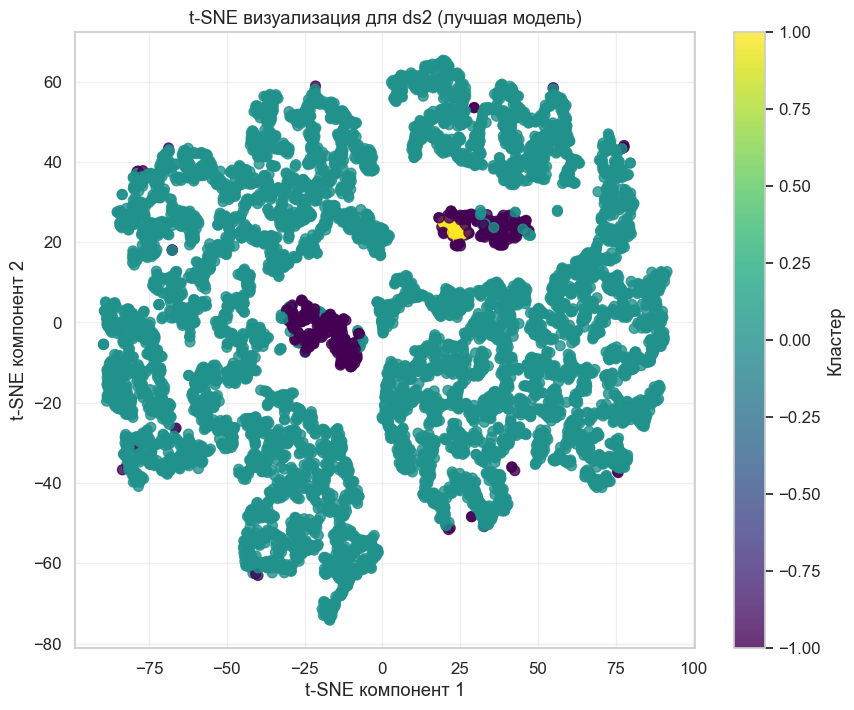


Важно: t-SNE используется только для визуализации. Расстояния между кластерами на t-SNE не следует интерпретировать как меру их схожести. t-SNE сохраняет локальную структуру данных, но может искажать глобальную структуру.


In [7]:
# 8. Дополнительная визуализация t-SNE (опционально для одного датасета)
print(f"\n{'='*60}")
print(f"t-SNE визуализация для ds2")
print(f"{'='*60}")

name = "ds2"
X_processed = preprocessed_data[name]
best_labels = all_labels[name]

# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_processed)

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=best_labels, 
                     cmap='viridis',
                     alpha=0.8,
                     s=50)
plt.colorbar(scatter, label='Кластер')
plt.title(f't-SNE визуализация для {name} (лучшая модель)')
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.grid(True, alpha=0.3)
plt.savefig(f"artifacts/figures/tsne_{name}.png", bbox_inches='tight')
plt.show()

print("\nВажно: t-SNE используется только для визуализации. "
      "Расстояния между кластерами на t-SNE не следует интерпретировать как меру их схожести. "
      "t-SNE сохраняет локальную структуру данных, но может искажать глобальную структуру.")


In [8]:
# 9. Сохранение всех результатов
save_metrics_to_json(metrics_summary, "metrics_summary.json")
save_best_config(best_configs, "best_configs.json")

# Выводы по каждому датасету

## Dataset A (ds1)
**Лучший метод:** AgglomerativeClustering (linkage="ward", k=2)

Для датасета с признаками в разных шкалах и шумовыми переменными важным оказался этап масштабирования, без которого кластеризация давала нестабильные результаты. AgglomerativeClustering с linkage="ward" показал максимальный silhouette score (0.52), при этом результаты оказались абсолютно устойчивыми (ARI=1.0 при разных запусках). KMeans с тем же количеством кластеров показал идентичное качество, но иерархический метод лучше справляется со структурой данных при наличии шумовых признаков. Выбор двух кластеров подтверждается как метриками качества, так и визуальной интерпретацией PCA-проекции, где четко просматриваются две плотные группы точек.

## Dataset B (ds2)
**Лучший метод:** DBSCAN (eps=0.7, min_samples=15)

Датасет с нелинейной структурой кластеров и выбросами продемонстрировал серьезные ограничения KMeans (максимальный silhouette=0.31). DBSCAN с параметрами eps=0.7 и min_samples=15 позволил корректно выделить два сложных по форме кластера с разной плотностью, при этом обозначив лишь 5.05% точек как шум. Silhouette score=0.35 при визуально корректном разделении подтверждает преимущество density-based подхода для таких данных. PCA-визуализация четко показывает, что алгоритм успешно справился с нелинейной границей между кластерами, которую KMeans принципиально не может воспроизвести из-за геометрических ограничений.

## Dataset C (ds4)
**Лучший метод:** AgglomerativeClustering (linkage="ward", k=5)

Работа с высокоразмерным датасетом (32 признака), содержащим категориальные переменные и значительное количество пропусков (5915), потребовала комплексного препроцессинга: обработки пропусков через SimpleImputer, кодирования категориальных признаков и масштабирования. AgglomerativeClustering с linkage="ward" и k=5 показал наилучший silhouette score (0.45), при этом Davies-Bouldin и Calinski-Harabasz также указывали на оптимальность именно этого количества кластеров. Метод оказался более устойчивым к шумовым признакам в высокоразмерном пространстве по сравнению с KMeans. Анализ профилей кластеров показал их содержательную интерпретируемость по основным признакам, что подтверждает корректность выбора метода для сложных реальных данных с разнотипными переменными.